In [1]:
import os

import matplotlib.pyplot as plt
from torchvision import transforms
from generator import *
from discriminator import *
from feature_extractor import *
from trainer import *
from utils import *
from metrics import *
from edgeloss import *
from torch.utils.data import DataLoader
from torchsummary import summary

print(os.getcwd())
torch.cuda.empty_cache()

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# num = 100206
# img = ImagePair(number=num, root_dir='data')
# img_slice = img.img()['LR'][:,:,25]
# plt.imshow(img_slice, cmap='gray')

In [4]:
std = 0.3548

transform = transforms.Compose([
    ToTensor(),
    Normalize(std=std),
])

tra_set = ImagePairDataset('training', patients_frac=.5, transform=transform)
val_set = ImagePairDataset('validation', patients_frac=.5, transform=transform)

Load validation set	: 100%|███████████████| 15/15 [00:01<00:00,  7.95it/s]                                                             


Length of training set: 	3500
Length of validation set: 	750


(-0.5, 223.5, 223.5, -0.5)

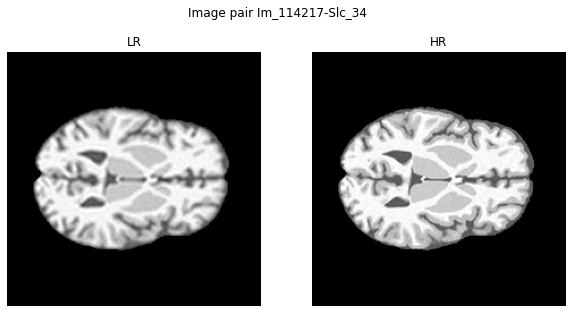

In [11]:
print('Length of training set: \t{}\nLength of validation set: \t{}'
      .format(len(tra_set),len(val_set)))

id = 25
sample = tra_set[id]
title = 'Image pair {}'.format(sample['id'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.set_facecolor('white')
fig.suptitle(title)
ax1.imshow(np.squeeze(sample['LR']),cmap='gray')
ax1.set_title('LR')
ax1.axis('off')
ax2.imshow(np.squeeze(sample['HR']),cmap ='gray')
ax2.set_title('HR')
ax2.axis('off')

In [12]:
batch_size = 8
n_cpu = 2
tra_dataloader = DataLoader(
    tra_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

val_dataloader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)


In [13]:
# generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1).cuda()
# summary(generator, (1, 224, 224))

In [14]:
# discriminator = Discriminator(input_shape=(1,224,224)).cuda()
# summary(discriminator, (1, 224, 224))

In [15]:
# batch = next(iter(tra_dataloader))
# writer = SummaryWriter('runs/test')
# writer.add_graph(generator, batch['LR'].cuda())
# writer.add_graph(discriminator, batch['LR'].cuda())

In [16]:
# mean, std = get_mean_and_std(tra_dataloader)
# print(mean, std)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1).to(device)
discriminator = Discriminator(input_shape=(1,224,224)).to(device)
feature_extractor = FeatureExtractor().to(device)

In [6]:
output_dir = 'runs/test'
start_epoch = 1
total_epochs = 10
lambda_edge = 1
lambda_pixel = 1
lambda_adv = 1
lambda_content = 1
trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    feature_extractor=feature_extractor,
    training_loader=tra_dataloader,
    validation_loader=val_dataloader,
    start_epoch=start_epoch,
    n_epochs=total_epochs,
    output_dir=output_dir,
    batch_size=batch_size,
    std=std,
    lambda_edge=lambda_edge,
    lambda_pixel=lambda_pixel,
    lambda_adv=lambda_adv,
    lambda_content=lambda_content,
)

metrics = trainer.fit()

Epoch 1


Validation: 100%|███████████████| 94/94 [00:25<00:00,  3.67it/s, loss_D=0.754, loss_G=1.222]                                           


Epoch 2


Validation: 100%|███████████████| 94/94 [00:23<00:00,  4.00it/s, loss_D=0.693, loss_G=0.999]                                           


Epoch 3


Validation: 100%|███████████████| 94/94 [00:25<00:00,  3.73it/s, loss_D=0.692, loss_G=1.081]                                           


Epoch 4


Validation: 100%|███████████████| 94/94 [00:23<00:00,  4.00it/s, loss_D=1.853, loss_G=2.008]                                           


Epoch 5


Validation: 100%|███████████████| 94/94 [00:24<00:00,  3.89it/s, loss_D=0.718, loss_G=1.003]                                           


Epoch 6


Validation: 100%|███████████████| 94/94 [00:23<00:00,  4.05it/s, loss_D=1.160, loss_G=1.227]                                           


Epoch 7


Validation: 100%|███████████████| 94/94 [00:24<00:00,  3.89it/s, loss_D=0.666, loss_G=1.080]                                           


Epoch 8


Validation: 100%|███████████████| 94/94 [00:23<00:00,  3.96it/s, loss_D=1.140, loss_G=1.822]                                           


Epoch 9


Validation: 100%|███████████████| 94/94 [00:24<00:00,  3.82it/s, loss_D=1.295, loss_G=0.771]                                           


Epoch 10


Validation: 100%|███████████████| 94/94 [00:24<00:00,  3.84it/s, loss_D=0.696, loss_G=0.970]                                           


In [49]:
torch.cuda.empty_cache()

In [19]:
output_dir = 'runs/test_edge'
test_set = ImagePairDataset('test', patients_frac=.5, transform=transform)
test_dataloader = DataLoader(
    test_set,
    batch_size=1,
    shuffle=True,
    num_workers=n_cpu,
)
state_dict = torch.load(output_dir+'/saved_models/10.model')
print('Model loaded, trained for {} epochs'.format(state_dict['epoch']))
generator.load_state_dict(state_dict['generator'])
generator.eval()
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

Load test set	: 100%|███████████████| 15/15 [00:01<00:00,  7.87it/s]                                                                   

Model loaded, trained for 10 epochs


In [21]:
ncc, ssim, nrsme = 0, 0, 0
for test_batch in tqdm(test_dataloader, bar_format='{l_bar}{bar:15}{r_bar}{bar:-15b}'):
    imgs_lr = Variable(test_batch['LR'].type(Tensor))
    imgs_hr = Variable(test_batch['HR'].type(Tensor))
    gen_hr = generator(imgs_lr)
    _ncc, _ssim, _nrsme = get_scores_batch(imgs_hr.cpu(), gen_hr.detach().cpu())
    ncc += _ncc
    ssim += _ssim
    nrsme += _nrsme

ncc = ncc/len(test_dataloader)
ssim = ssim/len(test_dataloader)
nrsme = nrsme/len(test_dataloader)

print('NCC:\t{:.4f}\nSSIM:\t{:.4f}\nNRSME:\t{:.4f}'.format(ncc, ssim, nrsme))

100%|███████████████| 750/750 [00:15<00:00, 47.35it/s]                                                                                 

NCC:	0.9991
SSIM:	0.9728
NRSME:	0.0367


<class 'pandas.core.series.Series'>


<function matplotlib.pyplot.show(close=None, block=None)>

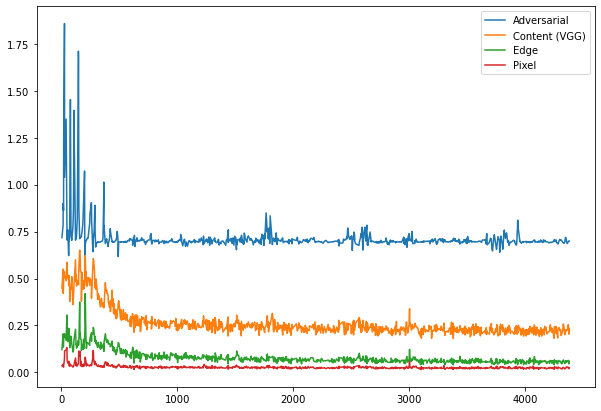

In [62]:
import pandas as pd
data1 = pd.read_csv(os.getcwd()+'/plots/run-Generator batch loss_Train_adversarial-tag-Generator batch loss.csv')
print(type(data1['Step']))
path = os.path.join(os.getcwd(), 'plots')
fname1 = 'run-Generator batch loss_Train_adversarial-tag-Generator batch loss.csv'
fname2 = 'run-Generator batch loss_Train_content-tag-Generator batch loss.csv'
fname3 = 'run-Generator batch loss_Train_edge-tag-Generator batch loss.csv'
fname4 = 'run-Generator batch loss_Train_pixel-tag-Generator batch loss.csv'
steps = pd.read_csv(os.path.join(path, fname1))['Step']
value1 = pd.read_csv(os.path.join(path, fname1))['Value']
value2 = pd.read_csv(os.path.join(path, fname2))['Value']
value3 = pd.read_csv(os.path.join(path, fname3))['Value']
value4 = pd.read_csv(os.path.join(path, fname4))['Value']
plt.figure(facecolor='white', figsize=(10,7))
plt.plot(steps,value1,label='Adversarial')
plt.plot(steps,value2,label='Content (VGG)')
plt.plot(steps,value3,label='Edge')
plt.plot(steps,value4,label='Pixel')
plt.legend()
plt.yscale('linear')
# plt.ylim(0, 1.25)
plt.savefig('test.png', dpi=350)
plt.show

In [20]:
#TODO
# -